## **1) Import libraries**

In [1]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import warnings
warnings.filterwarnings( "ignore")
from tqdm import tqdm
import time

import os
import networkx as nx

%matplotlib inline

## **2) Simulation model**

### **2.1) Model**

In [26]:
class Factory:
    def __init__(self, env, config) -> None:
        '''
            Initilizes the factory bases on the configuration
            
            Input: simpy environment, dictionary
            Output: 
        '''
        
        self.env = env
        
        ## Support variables
        self.TDem = 0
        self.TSales = 0
        self.TLC = 0
        self.TSC = 0
        self.THC = 0
        self.TCM = 0
        self.current_prod = None
        self.prod_log = []
        self.current = 0
        self.idle = simpy.Event(env)

        ## Demand configuration
        self.cv = config['cv']
        self.mod = config['mod']
        self.demand_mod = config['demand_mod']
        self.p_geo = config['p_geo']
        self.k_low = config['k_low']
        self.alpha_high = config['alpha_high']
        
        ## Cost configuration
        self.gross_margin = config['gross_margin']
        self.cmu = config['cmu']
        self.lc = config['lc']
        self.sc = config['sc']
        self.hc = config['hc']
        
        ## Production configuration
        self.rho = config['rho']
        self.n = config['n']

        ## Stock configuration
        self.Smax = config['Smax']
        self.Smin = config['Smin']
        
        ## Simulation configuration
        self.name = config['name']
        self.days = config['days_year']
        self.random_state = config['random_state'] 
        self.df_plot = None
        
        
        ## Setup demand distribution
        self.d = self.set_demand()
        
        ## Plot demand distribution
        if config['print_demand_dist'] == True:
            self.plot_demand_distribution()
        
        ## Setup production rate based on utilization rate
        self.mu = (int(self.gross_margin/self.cmu)/self.days)*self.rho
        
        ## Setup times of Machine <> Product
        self.setups = self.setup_times(config['setup0'], config['alpha'] )
        
        ## Setup arrival rate of products
        self.arrival_stats = {i: [self.mu_arrival(self.d[i], 
                                    config['random_state']*config['cv']*self.d[i]),
                                self.sigma_arrival(self.d[i], 
                                    config['random_state']*config['cv']*self.d[i]),
                                    self.d[i]] 
                                    for i in range(config['n'])}
        
        
        
        ## Defines initial stock level
        self.stock = self.set_initial_stock(config['initial_level'])
        
        ## Starts monitoring key indicators of the factory
        self.env.process(self.monitor(config))
        
        ## Defines scheduling mode of products (LDS, FIS)
        self.set_scheduling_mode()
        
        ## Defines if calculation of time taken by each process will be random or deterministic
        self.set_calc_time()
        
    def set_demand(self):
        '''
            Defines the demand distribution between products
            
            Input: 
            Output: dict
        '''
        
        ## Computes the total daily demand
        total_demand = int(self.gross_margin/self.cmu)/self.days
        
        ## Defines the distribution rate for scenarios
        k_low = self.k_low
        alpha_high = self.alpha_high
        
        ## Case 1: Uniform distribution
        if self.demand_mod == 'Low':
            
            demand_per_item = total_demand / self.n
            distribution = {i: demand_per_item for i in range(self.n)}
            
        ## Case 2: Low concentration
        elif self.demand_mod == 'Medium':
    
            demand_per_item = []
            total_powers = sum([i ** -k_low for i in range(1, self.n + 1)])
            for i in range(1, self.n + 1):
                demand = (total_demand / total_powers) * (i ** -k_low)
                demand_per_item.append(demand)
            distribution = {i: demand for i, demand in enumerate(demand_per_item)}
            
        
        ## Case 3: High concentration
        elif self.demand_mod == 'High':
            
            demand_per_item = []
            aux = total_demand * (alpha_high - 1) / (alpha_high ** alpha_high)
            for i in range(1, self.n + 1):
                demand = aux / (i ** alpha_high)
                demand_per_item.append(demand)

            # Normalize demands to match the total demand
            total_calculated_demand = sum(demand_per_item)
            normalization_factor = total_demand / total_calculated_demand
            normalized_demand_per_item = [demand * normalization_factor for demand in demand_per_item]
            
            distribution = {i: demand for i, demand in enumerate(normalized_demand_per_item)}
            
        ## Case 4: Geometric distribution
        elif self.demand_mod == 'Geometric':
            demand_per_item = []
            if self.p_geo != 0:
                geometric_sum = sum([self.p_geo * (1 - self.p_geo) ** (i - 1) for i in range(1, self.n + 1)])
                for i in range(1, self.n + 1):
                    demand = (total_demand / geometric_sum) * (self.p_geo * (1 - self.p_geo) ** (i - 1))
                    demand_per_item.append(demand)
                distribution = {i: demand for i, demand in enumerate(demand_per_item)}
            
            else:
                demand_per_item = total_demand / self.n
                distribution = {i: demand_per_item for i in range(self.n)}
            
        ## Case 5: Default case --> Uniform distribution
        else: 
            
            demand_per_item = total_demand / self.n
            distribution = {i: demand_per_item for i in range(self.n)}
            
        return distribution
           
    def set_initial_stock(self, mode):
        '''
            Defines the initial stock level
            
            Input: object
            Output: dict
        '''
        
        ## Case 1: Initial stock level = Smax
        if mode == 'Smax':
            stock = {i: simpy.Container(self.env, capacity = np.inf, 
                                           init = self.Smax[i]) for i in range(self.n)}
            
        ## Case 2: Initial stock level = Random integer
        elif mode == 'randint':
            stock = {i: simpy.Container(self.env, capacity = np.inf, 
                                           init = np.random.randint(self.Smin[i], self.Smax[i]+1)) for i in range(self.n)}
            
        ## Case 3: Initial stock level = Pre-determined level
        elif type(mode) != str:
            stock = {i: simpy.Container(self.env, capacity = np.inf, 
                                           init = mode[i]) for i in range(self.n)}
            
        ## Case 4: Initial stock level = Random number
        else: 
            stock = {i: simpy.Container(self.env, capacity = np.inf, 
                                           init = np.random.uniform(self.Smin[i], self.Smax[i])) for i in range(self.n)}
            
        return stock

    def set_scheduling_mode(self):
        '''
            Defines the scheduling model (LDS or FIS)
            
            Input: 
            Output: 
        '''
        
        ## Case 1: Default = LDS
        if self.mod not in ['LDS', 'FIS']:
            self.mod = 'LDS'
        
        ## Case 2: FIS
        if self.mod == 'FIS':
            def schedule(self):
                
                ## Sort production backlog
                self.prod_log.sort()
                
                ## Selects first product
                product_id = self.prod_log.pop(0)
                self.current_prod = product_id
                
                return product_id
            
        ## Case 2: LDS
        if self.mod == 'LDS':
             def schedule(self):
                ## Days of Supply
                dos = [float(self.stock[i].level/self.d[i]) for i in self.prod_log]
        
                ## Sort production backlog based on days of supply
                self.prod_log = [x for _, x in sorted(zip(dos, self.prod_log))]
                
                ## Selects products with lowest days of supply
                product_id = self.prod_log.pop(0)
                self.current_prod = product_id
                
                return product_id
        
        ## Defines scheduling fuction
        self.schedule_mode = schedule

    def set_calc_time(self):
        '''
            Defines the calculation mode of time taken by each process (stochastic or deterministic)
            
            Input: 
            Output: 
        '''
        
        ## If Stochastic
        if self.random_state == 1:
            def time(tempo_medio):
                if tempo_medio == 0:
                    return 0
                else:
                    return np.random.lognormal(self.mu_arrival(tempo_medio, tempo_medio*self.cv),self.sigma_arrival(tempo_medio, tempo_medio*self.cv) )
                
        ## If Deterministic
        else:
            def time(tempo_medio):
                ## Returns average time
                return tempo_medio
            
        ## Sets the chosen function as an attribute of the factory
        self.calc_formula = time
        
    def calc_time(self, tempo):
        '''
            Returns the time taken by the process based on the calculation mode defined previously
            
            Input: 
            Output: float
        '''
              
        return self.calc_formula(tempo)
    
    def select_next(self):
        '''
            Returns the product id of the next product to be produced
            
            Input: 
            Output: int
        '''
        
        return self.schedule_mode(self)
        
    def setup_times(self, setup0, alpha):
        '''
            Defines the average time taken to setup the machine when changing from product k to j
            
            Input: float, float
            Output: array
        '''
        
        n = self.n
        setups = np.zeros([n, n])
        
        for k in range(n):
            for j in range(n):
                if j < k:
                    setups[k][j] = n - 2 and (alpha + (n - 1 - k + j)*(alpha/(n-2)))*setup0 or alpha*setup0
                elif j > k:
                    setups[k][j] = n - 2 and (alpha + (j-k - 1 )*(alpha/(n-2)))*setup0 or alpha*setup0
                else:
                    setups[k][j] = 0
        return setups
        
    def mu_arrival(self, mu1, sigma1):
        '''
            Computes the average arrival rate
            
            Input: float, float
            Output: 
        '''
        
        if mu1>0:
            return math.log(mu1/math.sqrt(1 + (sigma1**2)/(mu1**2)))
        else:
            return 0
    
    def sigma_arrival(self, mu1, sigma1):
        '''
            Computes the standard deviation of arrival rate
            
            Input: float, float
            Output: 
        '''
        
        if mu1 >0:
            return math.sqrt(math.log(1 + (sigma1**2)/(mu1**2)))
        else:
            return 0
           
    def monitor(self, config):
        '''
            Collects key KPIs (ex: cost) of the factory every 24h and store them into a dataframe
            
            Input: 
            Output: 
        '''
        
        ## Checks initital state
        self.df_plot = pd.DataFrame.from_dict(data = dict(**{'Time': self.env.now, 'Day': int(self.env.now/24)}, **{'Product ' + str(product): [self.stock[product].level] for product in range(config['n'])}))
        
        while True:
            
            ## Collects data every 24h
            yield self.env.timeout(24)
            self.df_plot = self.df_plot.append(pd.DataFrame(pd.Series(data = dict(**{'Time': self.env.now, 'Day': int(self.env.now/24)}, **{'Product ' + str(product): self.stock[product].level for product in range(config['n'])}))).T)
            self.THC += self.hc*np.sum([self.stock[i].level for i in self.stock]) 
    
    def sales(self):
        '''
            Starts order arrivals for each product
            
            Input: 
            Output: 
        '''
        
        ## Starts order arrivals for each product
        for product_id in range(self.n):
            self.env.process(self.arrival(product_id))
        yield self.env.timeout(0)
            
    def get_order_qty(self, product_id):
        '''
            Computes the order quantity 
            
            Input: int
            Output: 
        '''
        
        ## Deterministic
        if self.random_state == 0:
            return self.arrival_stats[product_id][2]
        
        ## Stochastic
        else:
            if self.arrival_stats[product_id][0] == 0:
                return 0
            
            ## Lognormal distribution
            else:
                return np.max([int(np.round(np.random.lognormal(self.arrival_stats[product_id][0],
                                            self.arrival_stats[product_id][1], 
                                            1),0)), 0])    

    def arrival(self, product_id):  
        '''
            Simulates the arrival of orders for a certain product
            
            Input: int
            Output: 
        '''        
        
        ## Simulates order arrivals for each product 
        while True:
            
            ## Computes order quantity
            order_qty = self.get_order_qty(product_id)

            ## Computes quantity sold based on available stock
            sales_qty = np.min([self.stock[product_id].level, order_qty])
            
            ## If sold
            if sales_qty >0:
                
                ## Gets items from stock
                self.stock[product_id].get(sales_qty)
            
            ## If new stock level is lower than replenishment point
            if self.stock[product_id].level < self.Smin[product_id]:
                
                ## If product not in log nor in prouction
                if product_id not in self.prod_log and product_id != self.current_prod:
                    ## Adds product id to production log
                    self.prod_log.append(product_id)

                if self.idle.triggered:
                    pass
                else:
                    self.idle.succeed()
                    
            ## Updates KPIs
            self.TSales += sales_qty
            self.TDem += order_qty
            self.TLC += (order_qty - sales_qty)*self.lc

            ## Daily demands (simulates 24h)
            yield self.env.timeout(24)
            
    def production(self):  
        '''
            Simulates the production process
            
            Input: 
            Output: 
        '''     
        
        while True:    
            
            ## Waits until production module is activated
            yield self.idle
            
            ## Selects product prioritized
            product_id = self.select_next()

            ## Computes quantity to be produced based on current stock level
            prod_qty = self.Smax[product_id] - self.stock[product_id].level
            
            ## Setup of machine
            time_setup = self.calc_time(self.setups[self.current][product_id])
            yield self.env.timeout(time_setup)
            
            ## Computes setup cost
            if self.current != product_id:
                self.TSC += self.sc
            self.current = product_id
    
            ## Simulates production time
            time_produce = self.calc_time(prod_qty/self.mu*24)
            yield self.env.timeout(time_produce) ## days to hours
            
            ## Adds items to stock
            self.stock[product_id].put(prod_qty)
            self.current_prod = None
            
            ## If production back log is empty
            if len(self.prod_log) == 0:
                ## Then set production module as idle
                self.idle = simpy.Event(self.env)       
            else:
                pass

    def plot_demand_distribution(self):
        '''
            Plots the daily demand distribution for each product
            
            Input: 
            Output: 
        '''
    
        fig = plt.figure(figsize=(15,5))

        ## Defines data to plot
        x = ['SKU ' + str(id) for id in self.d.keys()]
        y = self.d.values()
    
        ## Plots data
        plt.bar(x, y) 

        ## Configures plot style
        plt.title('Daily demand per SKU', weight = 'bold')
        plt.xlabel('Product ID', weight = 'bold')
        plt.ylabel('Daily demand [units/day]', weight = 'bold')

        plt.grid(axis='both', alpha=.3)

        # Remove borders
        plt.gca().spines["top"].set_alpha(0.0)    
        plt.gca().spines["bottom"].set_alpha(0.3)
        plt.gca().spines["right"].set_alpha(0.0)    
        plt.gca().spines["left"].set_alpha(0.3)


In [3]:

def problem(config, print_on = False): 
    '''
        Runs the simulation, collects its data, returns/prints main results
        
        Input: dict, boolean
        Output: object, dict
    '''
        
        
    ## Creates Simpy environment
    env = simpy.Environment()
    
    ## Creates the Factory on the environment created and based on th simulation configuration
    factory = Factory(env, config)
    
    ## Starts sales and production process of Simpy
    sales_process = env.process(factory.sales())
    production_process = env.process(factory.production())
    
    ## Prints support messages
    if print_on:
        print('==============')
        print('Simulation Started')
    
    ## Runs the simulation
    env.run(config['simulation_time'])

    ## Prints support messages
    if print_on:
        print('Days simulated: %i' %(config['simulation_time']/24))
        print('Simulation Ended')
        print('==============')

    # Monitors inventory for the last time
    factory.df_plot = factory.df_plot.append(pd.DataFrame(pd.Series(data = dict(**{'Time': factory.env.now, 'Day': int(factory.env.now/24)}, **{'Product ' + str(product): factory.stock[product].level for product in range(config['n'])}))).T)
    factory.THC += factory.hc*np.sum([factory.stock[i].level for i in factory.stock]) 
    
    ## Computes Total contribution margin
    factory.TCM = factory.TSales*factory.cmu
    
    ## Computes performance indicators (per year)
    days_year = config['days_year']
    TIC = float((factory.THC + factory.TLC + factory.TSC)/((config['simulation_time']/24)/days_year))
    THC = float((factory.THC )/((config['simulation_time']/24)/days_year))
    TLC = float((factory.TLC )/((config['simulation_time']/24)/days_year))
    TSC = float((factory.TSC )/((config['simulation_time']/24)/days_year))
    TCM = float((factory.TCM )/((config['simulation_time']/24)/days_year))
    SL = float(factory.TSales/factory.TDem)
    
    ## Prints main results
    if print_on:
        print('Performance indicators:')
        print(f'TIC: {TIC:,.2f} \nTHC: {THC:,.2f}  | TLC: {TLC:,.2f}  | TSC: {TSC:,.2f}  \n Total Contribution Margin: {TCM:,.2f} \n SL: {SL*100:,.2f}% ')
        
    return factory, {'TIC': TIC, 'THC': THC, 'TLC': TLC, 'TSC': TSC, 'TCM': TCM, 'SL': SL}
    
def plot_monitor(factory, indicators, config):
    '''
        Plots the evolution of stock levels and key KPIs
        
        Input: object, dict
        Output: 
    '''
    
    fig = plt.figure(figsize=(15,5))

    ## Defines data to plot
    x = np.arange(len(factory.df_plot['Day']))
    y = factory.df_plot[['Product ' + str(i) for i in range(factory.n)]]

    ## Defines colors to be used
    colors = plt.cm.tab10(np.linspace(0, 1, factory.n))

    ## Iterates over the columns and plots with colors established
    for i, column in enumerate(y.columns):
        plt.plot(x, y[column], color=colors[i], label=column, drawstyle="steps-post")
    
    ## If (s, S) are the same for all products, then it draws those lines
    if len(set(config['Smin'].values())) == 1:
        Smin = sum(config['Smin'].values())/len(config['Smin'])
        Smax = sum(config['Smax'].values())/len(config['Smax'])
        plt.axhline(y = Smin, color = 'r', linestyle = 'dashed', label ='Reorder point', alpha = 0.6)
        plt.axhline(y = Smax, color = 'black', linestyle = 'dashed', label ='Smax', alpha = 0.3)

    ## Setups legend for the plot
    legend = plt.legend(loc='best', bbox_to_anchor=(1,1),
            fancybox=True, shadow=True, ncol=1)

    ## Configures plot style
    max_y = max(config['Smax'].values())
    plt.ylim(bottom = 0, top = max_y + 10)
    plt.title('Inventory', weight = 'bold')
    plt.xlabel('Days', weight = 'bold')
    plt.ylabel('Inventory level', weight = 'bold')

    plt.grid(axis='both', alpha=.3)

    # Remove borders
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)

    if np.isnan(indicators['SL']):
        indicator_sl = 1
    else:
        indicator_sl = indicators['SL']
        
    # Creates the textbox
    textbox_text = f"THC: R$ {indicators['THC']:,.2f}\nTLC: R$ {indicators['TLC']:,.2f}\nTSC: R$ {indicators['TSC']:,.2f}\n\nTIC: R$ {indicators['TIC']:,.2f}\nSL: {indicator_sl*100:.2f}%"
    textbox = plt.text(1.01,0.1, textbox_text,
                   ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'), transform=plt.gca().transAxes)


### **2.2) Simulation example**

Production rate:  90.0
CMU:  40
Total demand simulated:  4999.9999999999945
Total sales simulated:  4999.9999999999945
Total daily demand:  100.00000000000003
Total annual demand:  25000.000000000007
Total margin:  999999.9999999988


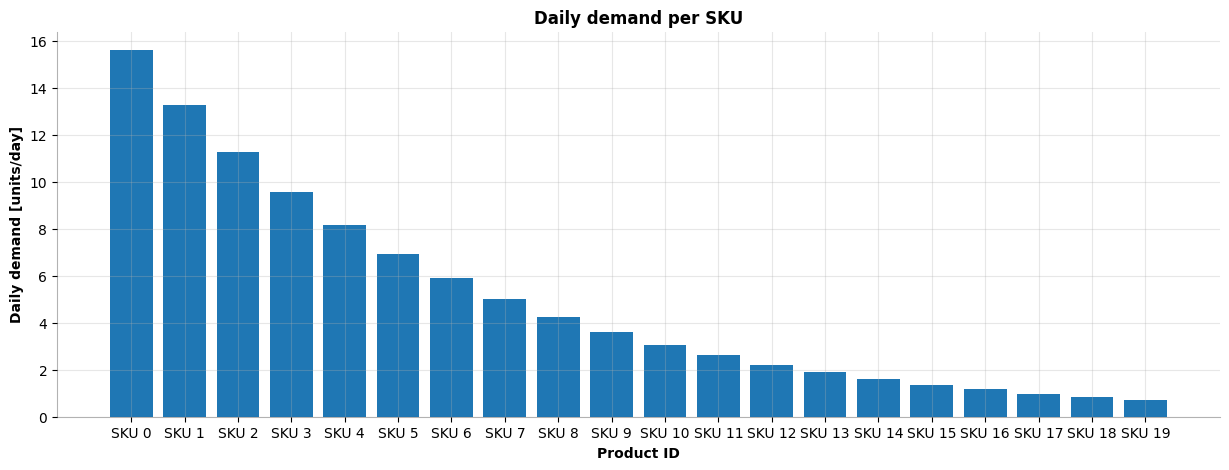

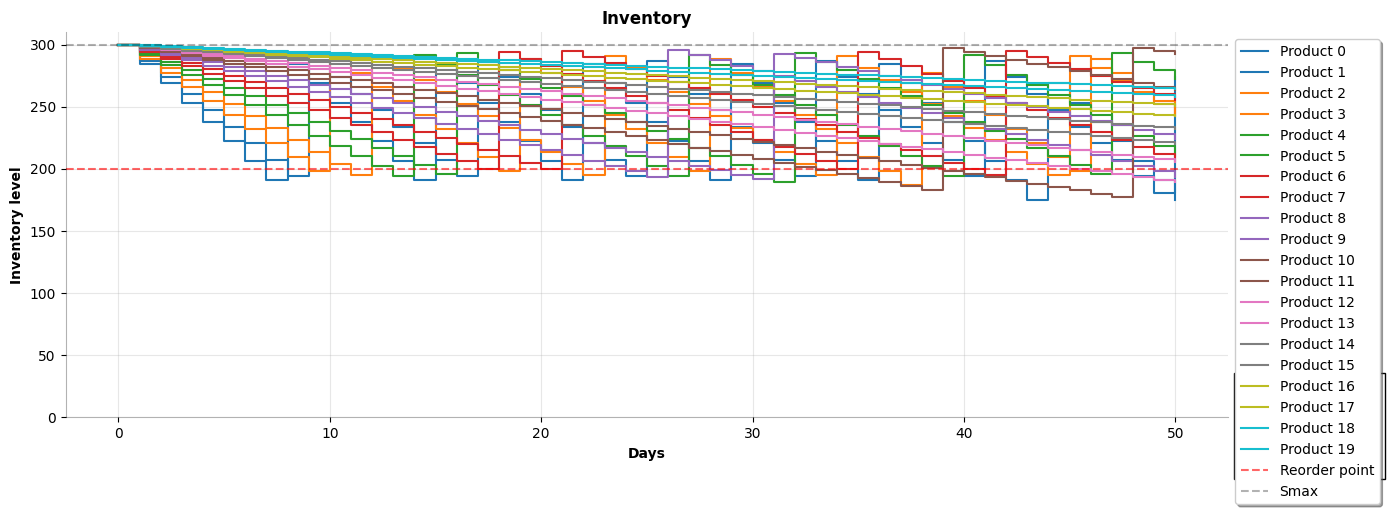

In [4]:
N = 20
config = {'simulation_time': 24*50,                  ## in hours
          'name': 'Simulation test',    
          'mod': 'LDS',                              ## {FIS, LDS}
        
          'n': N,                                    ## Number of items
          'exp_number': 0,                           ## Experiment number
          
          'cv': 0.0,                                 ## Demand coefficient of variation
          'alpha': 0,                                ## Maximum setup increment
          'rho': 0.9,                                  ## Utilization rate
          
          'demand_mod': 'Geometric',                 ## Demand concentration: {Low, Medium, High, Geometric}
          'p_geo': 0.15,                              ## Success probability of Geometric distribution
          'k_low': 0.5,                              ## Concentration rate for Medium level
          'alpha_high': 1.5,                         ## Concentration rate for High level
          'print_demand_dist': True,                 ## Plot demand distribution {True, False}
        
          'setup0': 1,                               ## Base setup time
          'gross_margin': 1000000,                   ## Gross margin
          'cmu': 40,                                 ## Contribution margin per unit
          'sc': 250,                                 ## Setup cost
          'lc': 40,                                  ## Lost sales cost
          'hc': 0.1,                                 ## Daily holding cost
          
          'Smax': {i: 300 for i in range(N)},        ## Order-up-to level
          'Smin': {i: 200 for i in range(N)},        ## Average daily demand
        
          'initial_level': 'Smax',                   ## Initial stock level; {Smax, randint, random, list any number}
          'days_year': 250,                          ## Working days per year
          'random_state': 0                          ## Randomness {0,1}
}


## Runs the simulation
factory, indicators = problem(config, False)
plot_monitor(factory, indicators, config)

print('Production rate: ', factory.mu)
print('CMU: ', factory.cmu)
print('Total demand simulated: ', factory.TDem)
print('Total sales simulated: ',factory.TSales)

print('Total daily demand: ', sum(factory.d.values()))

print('Total annual demand: ',sum(factory.d.values())*factory.days)
print('Total margin: ', indicators['TCM'])


## **3) Optimization model**

### **3.0) Support functions**

In [5]:
def set_config(config, point, name):
    '''
        Configures the simulation based on the choosen scenario (Smin and Smax)
        
        Input: dict, list, str
        Output: dict
    '''
    
    ## Number of products
    n = config['n']
    
    ## Other settings
    config_point = config
    config_point['name'] = name
    
    ## Fixing Smin and Smax given the scenario to be simulated
    config_point['Smax'] = {i: point[:len(point)//2][i] for i in range(n)}
    config_point['Smin'] = {i: point[len(point)//2:][i] for i in range(n)}
    
    return config_point

def get_performance(reps, config, point, name):
    '''
        Runs the simulation model based on the given configutation and gets all KPIs
        
        Input: int, dict, list, str
        Output: float, float
    '''
    
    ## Setup configuration
    config_sim = set_config(config, point, name)
    
    l_cost = []
    l_sl = []
    
    ## Repeats the simulation of the scenario 
    for k in range(reps):
        
        ## Simulation
        _,indicators = problem(config_sim, False)
        
        ## KPIs
        f = indicators['TIC']
        sl = indicators['SL']
        l_cost.append(f)
        l_sl.append(sl)
    
    return np.mean(l_cost), np.mean(l_sl)

def plot_evolution_best(x_label, title, results, support_line):
    '''
        Plots the evolution of the best solution as well as the average cost for each iteration (optional)
        
        Input: str, str, dict, str
        Output: 
    '''
    
    ## Creates a figure and axis object
    fig, ax = plt.subplots(figsize = (15,5))

    ## Plots the values as a line graph (best solution)
    ax.plot(results['l_best'], color = 'r', label = 'Best solution')
    
    ## Plots average cost of each iteration
    if support_line != None :
        ax.scatter(np.arange(0,len(results['l_all']),1),results['l_all'], s = 4, alpha = 0.5, label = support_line)
        

    ## Sets the x and y axis labels
    ax.set_xlabel(x_label, weight = 'bold')
    ax.set_ylabel('Total Inventory Cost', weight = 'bold')

    ## Set the title of the graph
    ax.set_title(title + ' (' + x_label + ' simulated = ' + str(len(results['l_best'])) + ')', weight = 'bold')
    ax.legend()
    plt.grid(axis='both', alpha=.3)

    ## Remove borders
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)

    ## Show the graph
    plt.show()


### **3.1) Random**

In [6]:
def random_opt(flags, config):
    '''
        Performs a random search of the best solution by testing as many solution as 
        possible during a limited time. At each iteration it tests a scenario and compares
        the result with the current best solution.
        
        Input: dict, dict
        Output: dict
    '''
    
    ## Number of products
    n = flags['N']    
    
    ## Support variables
    l_all = []
    l_best = []
    overall_best = None
    overall_best_cost = np.inf
    overall_best_sl = 0
    count_same_best = 0
    
    ## Gets the current time 
    start_time = time.time()  
    iter_times = []  

    ## Main loop of the Search method
    with tqdm(total=flags['n_iter_random'], ncols=70, disable=not(flags['tqdm']), desc='Random search') as pbar:
        
        for k in range(flags['max_iter_NM']):
            
            ## Establishes a candidate solution randomly
            Smax = [flags['S_lb'] + np.random.uniform(0.0, 1.0)*( flags['S_ub'] -  flags['S_lb']) for i in range(n)]
            Smin = [np.random.uniform(0, Smax[i]) for i in range(n)]
            candidate = Smax + Smin 

            ## Tests the performance of the candidate solution
            f, sl = get_performance(config['reps'], config, candidate, 'Random search')
            
            ## Compares the candidate to the current best solution
            if f < overall_best_cost:
                overall_best_cost = f
                overall_best = candidate
                overall_best_sl = sl
            l_best.append(overall_best_cost)
            l_all.append(f)
            
            ## Updates the progress bar
            pbar.update(1)

            ## Saves the time of the current iteration 
            elapsed_time = time.time() - start_time
            iter_times.append(elapsed_time)  
            
            ## Stops the Search method if time's up
            if elapsed_time >= flags['max_time']:
                break

    ## Saves the best solution
    best_point = {'Smax': set_config(config, overall_best, 'best')['Smax'], 'Smin': set_config(config, overall_best, 'best')['Smin']}
    best_cost = overall_best_cost
    best_sl = overall_best_sl*100

    results = {'best_point': best_point, 
               'best_cost': best_cost,
               'best_sl': best_sl,
               'l_best': l_best,
               'l_all': l_all,
               'l_time':iter_times} 
    
    return results


### **3.2) Nelder-Mead**

In [7]:
def restrict(point): 
    '''
        Restricts the candidate solution so it becomes feasible by enforcing that:
        - All values are non-negative
        - Smax > Smin
        
        Input: list
        Output: list
    '''
    
    ## Gets the number of variables
    n = len(point)
    
    ## Enforces positive constraint
    point = np.maximum(point, 0) 
    
    ## Enforces additional constraint (Smax > Smin)
    point[n//2:] = np.minimum(point[n//2:], point[:n//2]) 
    
    return point

def shrink(simplex, rho, p_l, config,f_l, sl_l):
    '''
        Shrinks the Simplex towards the point with the lowest cost in the Nelder-Mead Search method
        
        Input: list, float, list, dict, list, list
        Output: list, list, list
    '''
    
    ## Support variables
    simplex_shrink = []
    cost_shrink = []
    l_sl_shrink = []

    simplex_shrink.append(p_l)
    cost_shrink.append(f_l)
    l_sl_shrink.append(sl_l)
    
    ## For each point in the Simplex (except the best)
    for point in simplex[1:]:
        
        ## Shrinks towards the best point
        point_shrinked = restrict(p_l + rho*(point - p_l))
        simplex_shrink.append(point_shrinked)
        
        ## Tests the new candidate
        f_shrink, sl_shrink = get_performance(config['reps'], config, point_shrinked, 'Shrink')
        
        cost_shrink.append(f_shrink)
        l_sl_shrink.append(sl_shrink)
        
    return simplex_shrink, cost_shrink, l_sl_shrink
 
def nelder_mead(flags, config):
    '''
        Performs a Nelder-Mead optimization based on the configuration set.
        
        Input: dict, dict
        Output: dict
    '''
    
    ## Dimension of the problem
    n = flags['N']

    ## Hyper-parameters
    alpha = flags['Reflection_rate']
    beta = flags['Expansion_rate']
    gamma = flags['Contraction_rate']
    rho = flags['Shrinkage_rate']

    ## Defines the initial simplex (randomly)
    simplex_0 = []

    for k in range(n+1):
        Smax = [np.round(flags['S_lb'] + np.random.uniform(0.0, 1.0)*( flags['S_ub'] -  flags['S_lb']),2) for i in range(n)]
        Smin = [np.random.uniform(0, Smax[i]) for i in range(n)]
        simplex_0.append(Smax + Smin)
    
    ## Evaluates the initial simplex
    costs_simplex = []
    sl_simplex = []
    simplex = simplex_0
    for point in simplex:
        ## Adds cost to list
        f, sl = get_performance(config['reps'], config, point, 'Initial simplex')
        costs_simplex.append(f)
        sl_simplex.append(sl)
        
    ## Support variables
    l_mean_simplex = []
    l_best = []
    overall_best = None
    overall_best_cost = np.inf
    overall_best_sl = 0
    count_same_best = 0

    ## Gets the current time 
    start_time = time.time()
    iter_times = []
    
    ## Main loop of the Search method
    with tqdm(total=flags['max_iter_NM'], ncols=70, disable=not(flags['tqdm']), desc='Nelder-Mead') as pbar:
    
        for k in range(flags['max_iter_NM']):
            
            ## Sorts points by cost
            order = np.argsort(costs_simplex)
            simplex = list(np.array(simplex)[order])
            costs_simplex = list(np.array(costs_simplex)[order])
            avg_simplex = np.mean(costs_simplex)
            l_mean_simplex.append(avg_simplex)
            sl_simplex = list(np.array(sl_simplex)[order])
            
            ## Determines points with best, worst and second worst solutions (l, h, s)
            p_l, f_l, sl_l = simplex[0], costs_simplex[0], sl_simplex[0]
            p_h, f_h, sl_s = simplex[-1], costs_simplex[-1], sl_simplex[-1]
            p_s, f_s, sl_s = simplex[-2], costs_simplex[-2], sl_simplex[-2]
            
            ## Gets overall best
            if f_l < overall_best_cost:
                overall_best_cost = f_l
                overall_best = p_l
                overall_best_sl = sl_l
                count_same_best = 0
            else:
                count_same_best += 1
            l_best.append(overall_best_cost)
                
            ## Computes the centroid (without P_h)
            centroid = np.mean(simplex[:-1], axis=0)

            ## Reflection
            p_r = restrict(centroid + alpha*(centroid - p_h))
            f_r, sl_r = get_performance(config['reps'], config, p_r, 'Reflexion')
            
            ## Case 1
            if f_l <= f_r <f_s:
                ## Adds the reflected point to the Simplex
                simplex[-1] = p_r
                costs_simplex[-1] = f_r
                sl_simplex[-1] = sl_r

            ## Case 2
            elif f_r < f_l:
                
                ## Expansion
                p_e = restrict(centroid + beta*(p_r - centroid))
                f_e, sl_e = get_performance(config['reps'], config, p_e, 'Expansion')

                ## Case 2.1
                if f_e < f_r:
                    ## Adds the expanded point to the Simplex
                    simplex[-1] = p_e
                    costs_simplex[-1] = f_e
                    sl_simplex[-1] = sl_e
                    
                ## Case 2.2
                else:
                    ## Adds the reflected point to the Simplex
                    simplex[-1] = p_r
                    costs_simplex[-1] = f_r
                    sl_simplex[-1] = sl_r
            
            ## Case 3
            else:
                
                ## Contraction
                p_c = restrict(centroid + gamma*(p_h - centroid))
                f_c, sl_c = get_performance(config['reps'], config, p_c, 'Contraction')

                ## Case 3.1
                if f_c < f_h:
                    ## Adds the contracted point to the Simplex
                    simplex[-1] = p_c
                    costs_simplex[-1] = f_c
                    sl_simplex[-1] = sl_c

                ## Case 3.2
                else:
                    ## Shrinkage
                    ## Adds the shrinked point to the Simplex
                    simplex, costs_simplex, sl_simplex = shrink(simplex, rho, p_l, config, f_l, sl_l)
                    
            ## Updates the progress bar
            pbar.update(1)

            ## Saves the time of the current iteration 
            elapsed_time = time.time() - start_time
            iter_times.append(elapsed_time)  
            
            ## Stops the Search method if time's up
            if elapsed_time >= flags['max_time']:
                break
            
            ## Checks if other conditions are satisfied (ex: tolerance)
            if np.max(np.abs(np.array(costs_simplex) - costs_simplex[0])) <= flags['tol_NM'] or count_same_best >= flags['max_same_best_NM']:
                break

    ## Saves the best solution
    best_point = {'Smax': set_config(config, overall_best, 'best')['Smax'], 'Smin': set_config(config, overall_best, 'best')['Smin']}
    best_cost = overall_best_cost
    best_sl = overall_best_sl*100

    results = {'best_point': best_point, 
               'best_cost': best_cost,
               'best_sl': best_sl,
               'l_best': l_best,
               'l_all': l_mean_simplex,
               'l_time':iter_times}  

    return results



### **3.3) Genetic Algorithm**

In [8]:
def init_pop(flags):
    '''
        Creates a initial population for the Genetic-Algorithm with N candidates choosen randomly
        
        Input: dict
        Output: list
    '''
    
    population = []
    
    ## For each individual in the population
    for k in range(flags['N_pop_GA']):
        
        ## Defines a possible candidate randomly
        Smax = [np.round(flags['S_lb'] + np.random.uniform(0.0, 1.0)*( flags['S_ub'] -  flags['S_lb']),2) for i in range(flags['N'])]
        Smin = [np.random.uniform(0, Smax[i]) for i in range(flags['N'])]
        
        ## Adds the candidate to the population
        population.append(Smax + Smin)
    
    return population

def selection(cost_population, sl_population, population, N_keep):
    '''
        Selects the N best candidates in the population
        
        Input: list, list, list, int
        Output: list, list, list
    '''

    ## Selects best candidates
    parents = population[:N_keep]
    cost_parents = cost_population[:N_keep]
    sl_parents = sl_population[:N_keep]
    
    return parents, cost_parents, sl_parents

def crossover(beta, parents,flags, N_crossover_points, N_offspring):
    '''
        Creates the offsprings based on the chromossomes of the parentes
        
        Input: float, list, dict, int, int
        Output: list
    '''
    
    l_offspring = []
    
    ## While the population is incomplete
    while len(l_offspring) < (N_offspring):
        
        ## Random choice of parents - Selects two candidates and creates a couple
        random_couple = np.random.choice(len(parents),2, replace= False)
        father = random_couple[0]
        mother = random_couple[1]
        offspring = parents[father].copy()

        ## Ramdomly selects crossover points
        for point in np.random.choice(flags['N'],N_crossover_points, replace=False):
            
            ## For each crossover point, it mixes the chromossomes from the father and the mother
            offspring[point] = beta*parents[father][point] + (1-beta)*parents[mother][point]

        l_offspring.append(restrict(offspring).tolist())
    
    return l_offspring

def mutation(l_offspring, tau, flags):
    '''
        Mutates chromossomes of individuals
        
        Input: list, float, dict
        Output: list
    '''
    
    ## For each individual
    for offspring in l_offspring:
        
        ## Randomly selects chromossomes to mutate (Mutation rate equal to Tau)
        mutations = [i for i in range(flags['N']) if np.random.random() < tau]
        
        ## For each chromossome to mutate
        for gene in mutations:
            
            ## If Smax
            if gene < flags['N']:  ## i.e. Smax
                lb = offspring[gene + flags['N']]
                offspring[gene] = np.round(lb + np.random.uniform(0.0, 1.0)*( flags['S_ub'] -  lb),2)
                
            ## If Smin
            else:  ## i.e. Smin
                ub = offspring[gene - flags['N']]
                offspring[gene] = np.round(flags['S_lb'] + np.random.uniform(0.0, 1.0)*( ub -  flags['S_lb']),2)

    return l_offspring

def population_cost(population, config):
    '''
        Computes the cost of all individuals in the population
        
        Input: list, dict
        Output: list, list
    '''
    cost_population = []
    sl_population = []

    ## For each individual
    for individual in population:
        
        ## Computes the average cost and service level
        f, sl = get_performance(config['reps'], config, individual, 'Default')
        cost_population.append(f)
        sl_population.append(sl)

    ## Sort points by cost
    order = np.argsort(cost_population)
    population = list(np.array(population)[order])
    cost_population = list(np.array(cost_population)[order])
    sl_population = list(np.array(sl_population)[order])
    
    return cost_population, sl_population
    
def genetic_algorithm(flags, config):
    '''
        Performs a Genetic-Algorithm optimization based on the configuration set.
        
        Input: dict, dict
        Output: dict
    '''

    ## Setup of hyperparameters
    beta = flags['Blending_rate']
    tau = flags['mutation_rate']
    N_pop = flags['N_pop_GA']
    N_keep = int(np.round(N_pop*flags['Survivor_rate'],0))
    N_offspring = N_pop - N_keep
    N_crossover_points = int(flags['N']*flags['Crossover_rate'])
    N_generations = flags['N_generations']

    ## Creates the initial population
    population = init_pop(flags)
    new_gen = population.copy()

    
    ## Support variables
    l_best = []
    overall_best = None
    overall_best_cost = np.inf
    overall_best_sl = 0
    count_same_best = 0
    l_mean_pop = []
    
    ## Gets the current time 
    start_time = time.time() 
    iter_times = [] 
    
    ## Main loop of the Search method
    with tqdm(total=N_generations, ncols=70, disable=not(flags['tqdm']), desc='Genetic-Algorithm') as pbar:
        
        for k in range(N_generations):
            
            population = new_gen.copy()
            
            ## Computes the cost of each individual
            cost_population, sl_population = population_cost(population, config)
            
            ## Computes the average performance of the population
            avg_pop = np.mean(cost_population)
            l_mean_pop.append(avg_pop)
            
            ## Selects the best individuals to reproduce 
            parents, cost_parents, sl_parents = selection(cost_population,sl_population, population, N_keep)
            
            ## Creates offsprings
            l_offspring = crossover(beta, parents,flags, N_crossover_points, N_offspring)
            
            ## Performs mutations
            l_offspring = mutation(l_offspring, tau, flags)
            
            ## Creates the new population
            new_gen = parents + l_offspring


            ## Get overall best
            if cost_population[0] < overall_best_cost:
                overall_best_cost = cost_population[0]
                overall_best = population[0]
                overall_best_sl = sl_population[0]
                count_same_best = 0
            else:
                count_same_best += 1
            l_best.append(overall_best_cost)
            
            ## Updates the progress bar
            pbar.update(1)

            ## Saves the time of the current iteration 
            elapsed_time = time.time() - start_time
            iter_times.append(elapsed_time)  
            
            ## Stops the Search method if time's up
            if elapsed_time >= flags['max_time']:
                break
            
            ## Check if stop conditions satisfied
            if np.max(np.abs(np.array(cost_population) - cost_population[0])) <= flags['tol_GA']:
                break
    
    ## Saves the best solution
    best_point = {'Smax': set_config(config, overall_best, 'best')['Smax'], 'Smin': set_config(config, overall_best, 'best')['Smin']}
    best_cost = overall_best_cost
    best_sl = overall_best_sl*100

    results = {'best_point': best_point, 
               'best_cost': best_cost,
               'best_sl': best_sl,
               'l_best': l_best,
               'l_all': l_mean_pop,
                'l_time':iter_times} 
    
    

    return results
    

### **3.4) Ant Colony**

In [34]:
class AntColony():

    def __init__(self, flags, config):
        '''
            Initializes all necessary variables for the Ant Colony Optimization.
            Initializes the graph that represents the problem.
            
            Input: dict, dict
            Output: 
        '''
        
        
        ## Setup hyperparameters
        self.alpha = flags['Influence_pheromone']
        self.beta = flags['Influence_visibility']
        self.rho = flags['Evaporation_rate']
        self.Q = flags['Add_pheromone']
        self.nb_ant = flags['N_pop_ACO']
        
        self.method = flags['method_ACO']
        self.basic_config = config
        self.n_epochs = flags['n_epochs']
        self.tau_min = flags['tau_min']
        self.tau_max = flags['tau_max']
        self.n_to_convert = flags['n_to_convert']
        
        ## Defines the mesh for all all variables
        self.levels = self.define_levels(flags)
        
        ## Represents the problem as a graph
        self.graph = self.__init_graph()
        
        ## Initializes the ACO
        self.results = self.run(flags, config)
        
    def __init_graph(self):
        '''
            Represents the problem as a graph
            
            Input: 
            Output: graph
        '''
        
        graph = nx.DiGraph()
        
        ## Initializes nodes
        for level, choices in self.levels:
            
            ## For each variable, it creates a node for each possible value of the variable
            for choice in choices:
                graph.add_node((level, choice), level=level)
                
        ## Initialize connections
        for (name_i, choices_i), (name_j, choices_j) in zip(self.levels, self.levels[1:]):
            
            ## For each pair of values from two consecutive levels, it creates a connection (path) between the nodes
            for choice_i in choices_i:
                for choice_j in choices_j:
                    graph.add_edge((name_i, choice_i),
                                   (name_j, choice_j), tau=1, nu=1)
        return graph
    
    def define_levels(self, flags):
        '''
            Defines the mesh for all all variables
            
            Input: dict
            Output: list
        '''
        levels = [("init", ["init"])]

        ## For each product
        for k in range(flags['N']):
            
            ## Defines all possible values of Smax_i and Smin_i
            for var in ['Smax', 'Smin']:
                l_range = np.arange(flags['S_lb'],flags['S_ub'] + flags['step'], flags['step'])
                level_name = var + '_' + str(k)
                levels.append((level_name, l_range))
        
        return levels
       
    def pick_path(self):
        '''
            Chooses the path of an ant
            
            Input: 
            Output: list
        '''
        
        ## Support variable
        Smax_prev = np.inf
        
        ## Start from initial node
        path = [("init", "init")]
        
        ## For each level (each variable)
        for _ in range(len(self.levels)-1):
            
            ## Establishes all possible destinations
            items_view = self.graph[path[-1]].items()
            layer = [_[0] for (_, e) in items_view][0]
            
            ## Restricts destinations so it respects the constraints of the problem (Smin < Smax)
            if layer.startswith('Smin'):
                neighbors = [a for (a, _) in items_view if a[1] <= Smax_prev]
            else:
                neighbors = [a for (a, _) in items_view]
            neighbors_idx = np.arange(len(neighbors))

            ## Chooses a node according to weights
            tau = np.array([e["tau"]
                           for (_, e) in items_view if _ in neighbors], dtype=np.float32)
            nu = np.array([e["nu"] for (_, e) in items_view if _ in neighbors], dtype=np.float32)
            weights = (tau**self.alpha) * (nu**self.beta)
            weights /= np.sum(weights)
            chosen = neighbors[np.random.choice(neighbors_idx, p=weights)]
            
            if chosen[0].startswith('Smax'):
                Smax_prev = chosen[1]
            
            path.append(chosen)
            
            
        return path

    def update_tau(self, performances, pathes):
        '''
            Updates the amount of pheromone on each edge based on the method choosen
            
            Input: list, list
            Output: 
        '''
        
        ## Selected method
        method = self.method
        
        ## Basic Algorithm
        if method == 'basic':
            ## Evaporation:
            for origin, destiny in self.graph.edges(data=False):
                self.graph[origin][destiny]['tau'] = (
                    1-self.rho)*self.graph[origin][destiny]['tau']
            for path in pathes:
                for i in range(len(path)-1):
                    self.graph[path[i]][path[i+1]]['tau'] += self.Q / \
                        (1/self.graph[path[i]][path[i+1]]['nu'])

        ## ASrank
        if method == 'asrank':
            n_to_update = 5
            # Evaporation:
            for origin, destiny, edge in self.graph.edges(data=True):
                self.graph[origin][destiny]['tau'] = (
                    1-self.rho)*self.graph[origin][destiny]['tau']

            # Adding pheromone weighted by path's rank
            for path in pathes[:n_to_update]:
                weight = 1
                for i in range(len(path)-1):
                    self.graph[path[i]][path[i+1]]['tau'] += weight*self.Q / \
                        (1/self.graph[path[i]][path[i+1]]['nu'])
                weight += -1/n_to_update

        ## Elitist Ant System (Elistist AS)
        if method == 'elitist':
            ## Evaporation:
            for origin, destiny, edge in self.graph.edges(data=True):
                self.graph[origin][destiny]['tau'] = (
                    1-self.rho)*self.graph[origin][destiny]['tau']

            ## If extra_phero = 1, the ant adds 2 times more than other ants
            extra_phero = 1  
            
            ## Rewards best ant
            for i in range(len(pathes[0])-1):  
                self.graph[pathes[0][i]][pathes[0][i+1]]['tau'] += extra_phero * \
                    self.Q/(1/self.graph[pathes[0][i]][pathes[0][i+1]]['nu'])

            ## Adding pheromone
            for path in pathes:
                for i in range(len(path)-1):
                    self.graph[path[i]][path[i+1]]['tau'] += self.Q / \
                        (1/self.graph[path[i]][path[i+1]]['nu'])

        # MMAS
        if method == 'mmas':
            tau_min = self.tau_min
            tau_max = self.tau_max
            n_to_update = self.n_to_convert
            
            ## Evaporation
            for origin, destiny in self.graph.edges(data=False):
                update = (1-self.rho)*self.graph[origin][destiny]['tau']
                self.graph[origin][destiny]['tau'] = max(update, tau_min)

            # ## Only best ant adds pheromone
            # for i in range(len(pathes[0])-1):  
            #     increment = self.Q/(1/self.graph[pathes[0][i]][pathes[0][i+1]]['nu'])
            #     self.graph[pathes[0][i]][pathes[0][i+1]]['tau'] = min(
            #         self.graph[pathes[0][i]][pathes[0][i+1]]['tau'] + increment, tau_max)
                
                
            ## Adding pheromone weighted by path's rank
            
            for path_idx in range(n_to_update):
                path = pathes[path_idx]
                weight = performances[path_idx]/np.array(performances[:n_to_update]).sum()

                for i in range(len(path)-1):
                    self.graph[path[i]][path[i+1]]['tau'] += weight*self.Q / \
                        (1/self.graph[path[i]][path[i+1]]['nu'])
                    self.graph[path[i]][path[i+1]]['tau'] = min(
                        self.graph[path[i]][path[i+1]]['tau'], tau_max)
                weight -= 1/n_to_update

    def get_candidate(self, path):
        '''
            Defines the candidate solution based on the path chosen by the ant
            
            Input: list
            Output: list
        '''
        
        Smax = [value for level,value in path if level.startswith("Smax")]
        Smin = [value for level,value in path if level.startswith("Smin")]
        
        return Smax + Smin
          
    def epoch(self, config):
        '''
            Runs the routine for each generation of ants
            
            Input: dict
            Output: list, list, list
        '''
        
        ## Support variables
        pathes = []
        performances = []
        service_levels = []

        ## Routine for each ant
        for _ in range(self.nb_ant):
            
            ## Picks a path
            path = self.pick_path()
            pathes.append(path)
            candidate = self.get_candidate(path)
            
            ## Gets the performance of the candidate
            f, sl = get_performance(config['reps'], config, candidate, 'Ant colony')
            
            performances.append(f)
            service_levels.append(sl)

        ## Sort pathes based of the performance
        pathes = [path for _, path in sorted(zip(performances, pathes), key=lambda pair: pair[0])]
        serv_levs = [svl for _, svl in sorted(zip(performances, service_levels), key=lambda pair: pair[0])]
        performances.sort()
        
        ## Update pheromones
        self.update_tau(performances, pathes)

        return pathes, performances, serv_levs
    
    def run(self,flags, config):
        '''
            Performs an Ant Colony optimization based on the configuration set.
            
            Input: dict, dict
            Output: dict
        '''
        
        ## Support variables
        l_all = []  
        l_best = []
        overall_best = None
        overall_best_cost = np.inf
        overall_best_sl = 0
        count_same_best = 0

        ## Gets the current time 
        start_time = time.time()  # Get the current time
        iter_times = []  # List to store the times of each iteration
        
        ## Main loop of the Search method
        with tqdm(total=self.n_epochs, ncols=70, disable=not(flags['tqdm']), desc='Ant-Colony') as pbar:
        
            for k in range(self.n_epochs):
                
                ## Gets candidates and their performances            
                path, performances, service_levels = self.epoch(config)
                f = performances[0]
                candidate = self.get_candidate(path[0])
                sl = service_levels[0]
                
                ## Gets overall best
                if f < overall_best_cost:
                    overall_best_cost = f
                    overall_best = candidate
                    overall_best_sl = sl
                    
                l_best.append(overall_best_cost)
                l_all.append(np.mean(performances))
                
                ## Updates progress bar
                pbar.update(1)
                
                ## Saves the time of the current iteration 
                elapsed_time = time.time() - start_time
                iter_times.append(elapsed_time)  
                
                ## Checks if other conditions are satisfied 
                if elapsed_time >= flags['max_time']:
                    break
        
        ## Saves the best solution
        best_point = {'Smax': set_config(config, overall_best, 'best')['Smax'], 'Smin': set_config(config, overall_best, 'best')['Smin']}
        best_cost = overall_best_cost
        best_sl = overall_best_sl*100

        results = {'best_point': best_point, 
                'best_cost': best_cost,
                'best_sl': best_sl,
                'l_best': l_best,
                'l_all': l_all,
                'l_time':iter_times} 
        return results



## **4) Test models**

#### **4.0) Setup flags**

Defines the hyperparameters for each Search method as well as the variables of the problem to test the Optimization models

In [53]:
N = 5
flags = {'N': N,
        'reps': 3,
        'cv': 0.2,                
        'rho': 1,     
        'demand_mod': 'Geometric',
        'max_time': 1*60 , ## Max time (seconds)
        'tqdm': True,

        ## Random
        'n_iter_random': 1000,
        
        ## Nelder-Mead
        'Reflection_rate': 1.2,
        'Expansion_rate': 2,
        'Contraction_rate': 0.4,
        'Shrinkage_rate': 0.7,
        'max_iter_NM': 1000,
        'max_same_best_NM': 200,
        'tol_NM': 1,
        
        ## Genetic Algorithm
        'N_pop_GA': 20,
        'mutation_rate': 0.01,
        'N_generations': 200,
        'Survivor_rate': 0.5,
        'Blending_rate': 0.8,
        'Crossover_rate': 0.6,
        'tol_GA': 1,
        'max_same_best_GA': 50,

        ## ACO
        'N_pop_ACO': 18,
        'step': 5,
        'Influence_pheromone': 2,
        'Influence_visibility': 1,
        'Evaporation_rate': 0.1,
        'Add_pheromone': 2,
        'tau_min': 0.8,
        'tau_max': 25,
        'n_to_convert': 11,
        'method_ACO': 'mmas', ## {basic, asrank, elitist, mmas}
        'n_epochs': 100

        }

flags['S_ub'] = 1000000/40/250*10  ## The max stock level is the demand for 1 month of the best seller product
flags['S_lb'] = 0


config = {'simulation_time': 24*100,   ## in hours
         
         'mod': 'LDS',             ## {FIS, LDS}
         'initial_level': 'random',  ## Initial stock level
         'random_state': 1,         ## Randomness
         
         'name': 'default',
         'days_year': 250,         ## Working days per year
         
         'p_geo': 0.0,
         'k_low': 0.5,
         'alpha_high': 1.5,
         'print_demand_dist': False,                 ## Plot demand distribution {True, False}
         
         'alpha': 0,               ## Maximum setup increment
         'setup0': 1,        ## Base setup time
         'gross_margin': 1000000,  ## Gross margin
         'cmu': 40,                ## Contribution margin per unit
         'sc': 250,                ## Setup cost
         'lc': 40,                ## Setup cost
         'hc': 0.1,                ## Daily holding cost
         
         'demand_mod': flags['demand_mod'],      ## Demand concentration: {Low, Medium, High}
         'reps': flags['reps'],
         'n': flags['N'],                   ## Number of items
         'cv': flags['cv'],                ## Demand coefficient of variation
         'rho': flags['rho'],               ## Utilization rate
        
         'Smax': None,               ## Order-up-to level
         'Smin': None               ## Reorder point  
}





#### **4.1) Random**

Random search:  24%|███▌           | 237/1000 [01:00<03:13,  3.95it/s]

Best cost :  61975.522262851526
Best set :  {'Smax': {0: 547.0713497676929, 1: 468.2640474016968, 2: 447.9842794752593, 3: 601.3644704729699, 4: 469.256646010615}, 'Smin': {0: 306.6888198093859, 1: 112.54661100329717, 2: 388.0783582075521, 3: 166.16978357024558, 4: 206.49607723357798}}
Best SL :  99.095881515005


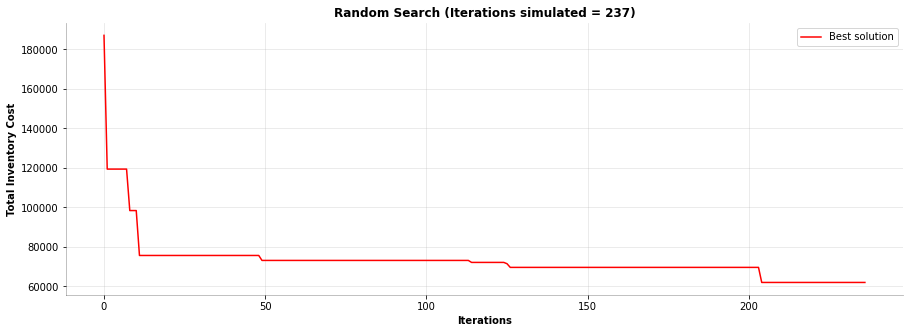

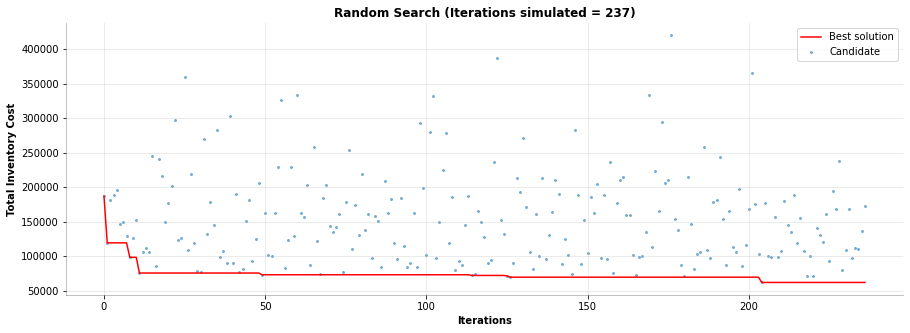

In [139]:
results_rand = random_opt(flags, config)

print('Best cost : ', results_rand['best_cost'])
print('Best set : ', results_rand['best_point'])
print('Best SL : ', results_rand['best_sl'])

x_label = 'Iterations'
title = 'Random Search'
support_line = None
plot_evolution_best(x_label, title, results_rand, support_line)

x_label = 'Iterations'
title = 'Random Search'
support_line = 'Candidate'
plot_evolution_best(x_label, title, results_rand, support_line)


#### **4.2) Nelder-Mead**

Nelder-Mead:  12%|██               | 124/1000 [01:00<07:08,  2.05it/s]

Best cost :  53976.4136242928
Best set :  {'Smax': {0: 402.5795769474387, 1: 466.6108471127462, 2: 480.6410156517557, 3: 364.4280555926699, 4: 432.38829779031886}, 'Smin': {0: 199.17761160275782, 1: 212.29176947944995, 2: 210.94946224256518, 3: 237.46117300878313, 4: 318.7545929656452}}
Best SL :  100.0


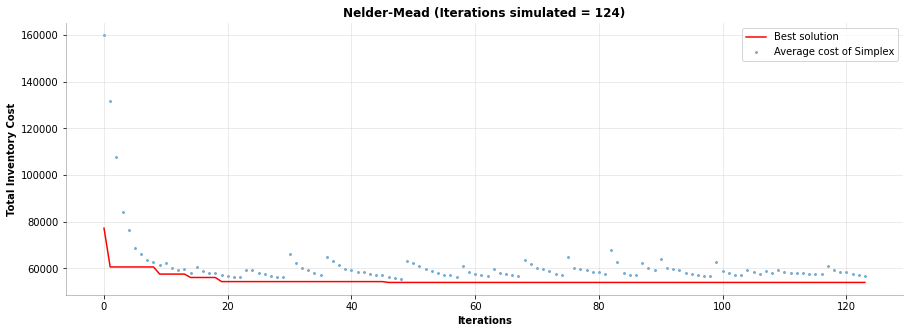

In [49]:
results_nm = nelder_mead(flags, config)
print('Best cost : ', results_nm['best_cost'])
print('Best set : ', results_nm['best_point'])
print('Best SL : ', results_nm['best_sl'])

x_label = 'Iterations'
title = 'Nelder-Mead'
support_line = 'Average cost of Simplex'
plot_evolution_best(x_label, title, results_nm, support_line)


#### **4.3) Genetic Algorithm**

Genetic-Algorithm:   0%|                      | 0/200 [00:00<?, ?it/s]

Genetic-Algorithm:   8%|█            | 16/200 [01:02<12:04,  3.94s/it]

Best cost :  63530.675789025765
Best set :  {'Smax': {0: 740.14, 1: 733.41, 2: 697.61, 3: 351.88, 4: 763.09}, 'Smin': {0: 303.4169628056359, 1: 6.462272754761352, 2: 371.24736143701017, 3: 307.11759198602215, 4: 183.78894253105403}}
Best SL :  99.99927096795572


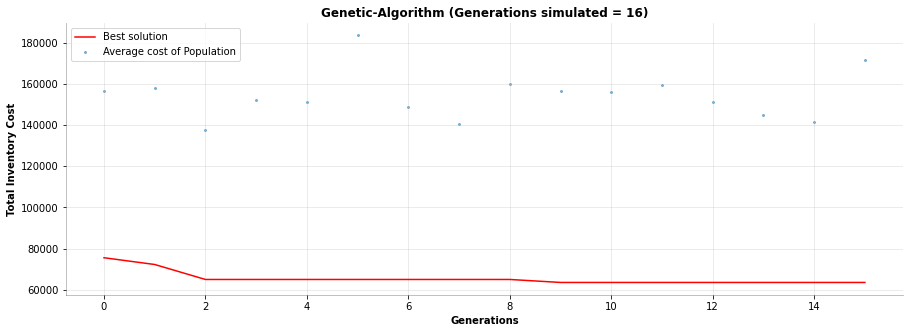

In [51]:
results_ga = genetic_algorithm(flags, config)
print('Best cost : ', results_ga['best_cost'])
print('Best set : ', results_ga['best_point'])
print('Best SL : ', results_ga['best_sl'])

x_label = 'Generations'
title = 'Genetic-Algorithm'
support_line = 'Average cost of Population'
plot_evolution_best(x_label, title, results_ga, support_line)


#### **4.4) Ant Colony**

Ant-Colony:  14%|██▊                 | 14/100 [01:02<06:20,  4.43s/it]

Best cost :  62613.44831253006
Best set :  {'Smax': {0: 560.0, 1: 640.0, 2: 715.0, 3: 845.0, 4: 335.0}, 'Smin': {0: 315.0, 1: 325.0, 2: 345.0, 3: 390.0, 4: 125.0}}
Best SL :  99.41728386120641


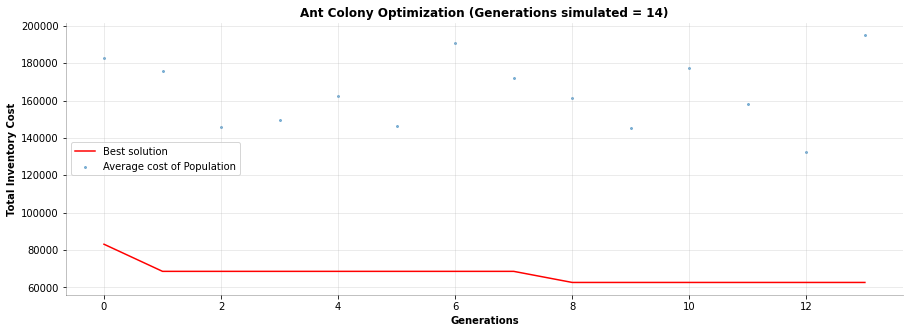

In [54]:
ant_colony = AntColony(flags, config)
results_aco = ant_colony.results

print('Best cost : ', results_aco['best_cost'])
print('Best set : ', results_aco['best_point'])
print('Best SL : ', results_aco['best_sl'])

x_label = 'Generations'
title = 'Ant Colony Optimization'
support_line = 'Average cost of Population'
plot_evolution_best(x_label, title, results_aco, support_line)

## **5) Benchmark**

In [348]:
def plot_benchmark_best(dict_all_methods):
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize = (15,5))


    # Plot the values as a line graph
    for method in dict_all_methods:
        ax.plot(dict_all_methods[method]['l_time'], dict_all_methods[method]['l_best'], label = 'Best solution - ' + method)
        
    
    # Set the x and y axis labels
    ax.set_xlabel('Elapsed time (seconds)', weight = 'bold')
    ax.set_ylabel('Total Inventory Cost', weight = 'bold')

    # Set the title of the graph
    ax.set_title('Benchmark of methods', weight = 'bold')
    ax.legend()
    ax.set_xlim(left=0)
    plt.grid(axis='both', alpha=.3)

    # Remove borders
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)

    # Show the graph
    plt.show()

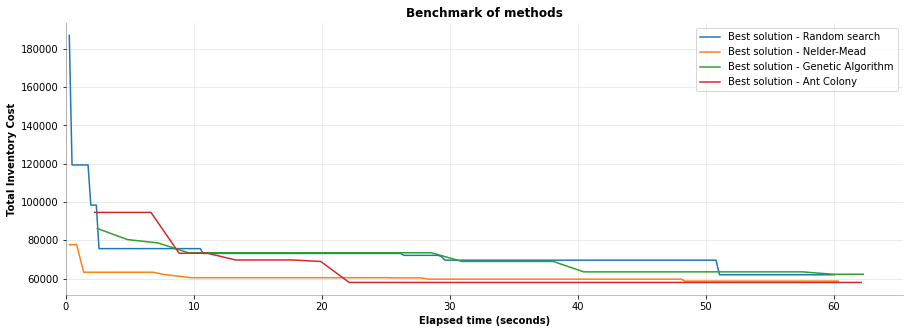

In [349]:
dict_all_methods = {'Random search': results_rand.copy(),
                    'Nelder-Mead': results_nm.copy(),
                    'Genetic Algorithm': results_ga.copy(),
                    'Ant Colony': results_aco.copy(),

                    }

plot_benchmark_best(dict_all_methods)


## **6) DoE**

In [55]:
def run_DoE(N_experiments,  file_name, max_time):
    df_doe = pd.read_excel(file_name, sheet_name= 'Results')
    
    flags = {'N': None,
            'reps': 3,
            'cv': None,                
            'rho': None,     
            'demand_mod': 'Geometric',
            'p_geo': None,
            'max_time': max_time, ## Max time (seconds)
            'tqdm': False,

            ## Random
            'n_iter_random': 1000,
            
             ## Nelder-Mead
            'Reflection_rate': 1.2,
            'Expansion_rate': 2,
            'Contraction_rate': 0.4,
            'Shrinkage_rate': 0.7,
            'max_iter_NM': 1000,
            'max_same_best_NM': 200,
            'tol_NM': 1,
            
            ## Genetic Algorithm
            'N_pop_GA': 20,
            'mutation_rate': 0.01,
            'N_generations': 200,
            'Survivor_rate': 0.5,
            'Blending_rate': 0.8,
            'Crossover_rate': 0.6,
            'tol_GA': 1,
            'max_same_best_GA': 50,

            ## ACO
            'N_pop_ACO': 8,
            'step': 5,
            'Influence_pheromone': 2,
            'Influence_visibility': 0,
            'Evaporation_rate': 0.25,
            'Add_pheromone': 1,
            'tau_min': 0.05,
            'tau_max': 30,
            'n_to_convert': 2,
            'method_ACO': 'mmas', ## {basic, asrank, elitist, mmas}
            'n_epochs': 100

            }

    flags['S_ub'] = 1000000/40/250*10  
    flags['S_lb'] = 0


    count = N_experiments
    for idx, row in tqdm(df_doe.iterrows(), total=count, desc='DoE'):
    
        if math.isnan(row['Cost']) and count>0:
            
            flags_exp = flags.copy()
            
            flags_exp['N'] = row['N']
            flags_exp['cv'] = row['cv']
            flags_exp['rho'] = row['rho']
            flags_exp['p_geo'] = row['p']
            
            
            config_exp = {'simulation_time': 24*100,   ## in hours
            
                    'mod': 'LDS',             ## {FIS, LDS}
                    'initial_level': 'random',  ## Initial stock level
                    'random_state': 1,         ## Randomness
                    
                    'name': 'default',
                    'days_year': 250,         ## Working days per year
                    
                    
                    'k_low': 0.5,
                    'alpha_high': 1.5,
                    'print_demand_dist': False,                 ## Plot demand distribution {True, False}
                    
                    'alpha': 0,               ## Maximum setup increment
                    'setup0': 1,        ## Base setup time
                    'gross_margin': 1000000,  ## Gross margin
                    'cmu': 40,                ## Contribution margin per unit
                    'sc': 250,                ## Setup cost
                    'lc': 40,                ## Setup cost
                    'hc': 0.1,                ## Daily holding cost
                    
                    'demand_mod': flags_exp['demand_mod'],      ## Demand concentration: {Low, Medium, High}
                    'p_geo': flags_exp['p_geo'],
                    'reps': flags_exp['reps'],
                    'n': flags_exp['N'],                   ## Number of items
                    'cv': flags_exp['cv'],                ## Demand coefficient of variation
                    'rho': flags_exp['rho'],               ## Utilization rate
                    
                    'Smax': None,               ## Order-up-to level
                    'Smin': None               ## Reorder point  
            }

        
            
            if row['algorithm'] == 'RD':
                results = random_opt(flags_exp.copy(), config_exp.copy())
                
            elif row['algorithm'] == 'NM':
                results = nelder_mead(flags_exp.copy(), config_exp.copy())
                
            elif row['algorithm'] == 'GA':
                results = genetic_algorithm(flags_exp.copy(), config_exp.copy())
                
            elif row['algorithm'] == 'ACO':
                ant_colony = AntColony(flags_exp.copy(), config_exp.copy())
                results = ant_colony.results
                
            count -= 1
            
            df_doe.loc[idx, 'Cost'] = results['best_cost']
            df_doe.loc[idx, 'SL'] = results['best_sl']
            df_doe.loc[idx, 'Smax'] = str(list(results['best_point']['Smax'].values()))
            df_doe.loc[idx, 'Smin'] = str(list(results['best_point']['Smin'].values()))
            
            
    df_doe.to_excel(file_name, sheet_name='Results', header=True, index=False)
                
    
    

In [60]:
N_experiments = 100

file_name = 'DoE/DoE - Results v4.xlsx'
max_time = 1*60
run_DoE(N_experiments, file_name, max_time)

DoE: 972it [1:43:57,  6.42s/it]             


## **7) Calibração**

In [37]:
def calibration(max_time, to_calibrate, N_exp):
    dict_calibration = { 
        'NM': {
        ## Nelder-Mead
        'Reflection_rate': {'min': 0.05, 'max': 2, 'step': 0.05},   
        'Expansion_rate': {'min': 0.05, 'max': 2, 'step': 0.05},   
        'Contraction_rate': {'min': 0.05, 'max': 2, 'step': 0.05},   
        'Shrinkage_rate': {'min': 0.05, 'max': 2, 'step': 0.05},   
        'max_iter_NM': 1000,
        'max_same_best_NM': 200,
        'tol_NM': 1},
        
        'GA': {
        ## Genetic Algorithm
        'N_pop_GA': {'min': 4, 'max': 20, 'step': 2},   
        'mutation_rate': {'min': 0.01, 'max': 0.1, 'step': 0.01},   
        'N_generations': 200,
        'Survivor_rate': {'min': 0.2, 'max': 0.8, 'step': 0.05},   
        'Blending_rate': {'min': 0.5, 'max': 1, 'step': 0.1},   
        'Crossover_rate': {'min': 0.25, 'max': 1, 'step': 0.05},   
        'tol_GA': 1,
        'max_same_best_GA': 50,
        },
        
        'ACO': {
        ## ACO
        'N_pop_ACO': {'min': 4, 'max': 20, 'step': 2},   
        'step': 5,
        'Influence_pheromone': {'min': 0, 'max': 3, 'step': 1},   
        'Influence_visibility': {'min': 0, 'max': 3, 'step': 1},   
        'Evaporation_rate': {'min': 0.05, 'max': 0.5, 'step': 0.05},   
        'Add_pheromone': {'min': 1, 'max': 3, 'step': 0.5},   
        'tau_min': {'min': 0.1, 'max': 2, 'step': 0.1},   
        'tau_max': {'min': 10, 'max': 30, 'step': 5},   
        'n_to_convert': {'min': 0.2, 'max': 0.8, 'step': 0.05},   
        'method_ACO': 'mmas', ## {basic, asrank, elitist, mmas}
        'n_epochs': 100
        }
    }
    
    flags = {'N': None,
            'reps': 3,
            'cv': None,                
            'rho': 0.8,     
            'demand_mod': 'Geometric',
            'p_geo': None,
            'max_time': max_time, ## Max time (seconds)
            'tqdm': False,

            ## Random
            'n_iter_random': 1000,
            
            ## Nelder-Mead
            'Reflection_rate': 1,   
            'Expansion_rate': 1,
            'Contraction_rate': 0.05,
            'Shrinkage_rate': 0.3,
            'max_iter_NM': 1000,
            'max_same_best_NM': 200,
            'tol_NM': 1,
            
            ## Genetic Algorithm
            'N_pop_GA': 12,
            'mutation_rate': 0.03,
            'N_generations': 200,
            'Survivor_rate': 0.7,
            'Blending_rate': 0.5,
            'Crossover_rate': 1,
            'tol_GA': 1,
            'max_same_best_GA': 50,

            ## ACO
            'N_pop_ACO': 8,
            'step': 5,
            'Influence_pheromone': 2,
            'Influence_visibility': 0,
            'Evaporation_rate': 0.25,
            'Add_pheromone': 1,
            'tau_min': 0.05,
            'tau_max': 30,
            'n_to_convert': 2,
            'method_ACO': 'mmas', ## {basic, asrank, elitist, mmas}
            'n_epochs': 100

            }

    flags['S_ub'] = 1000000/40/250*10  
    flags['S_lb'] = 0
    
    dict_exp = {0: {'N': 5, 'p': 0, 'cv': 0.1},
                1: {'N': 5, 'p': 0.15, 'cv': 0.1},
                2: {'N': 5, 'p': 0, 'cv': 0.5},
                3: {'N': 5, 'p': 0.15, 'cv': 0.5},
                4: {'N': 20, 'p': 0, 'cv': 0.1},
                5: {'N': 20, 'p': 0.15, 'cv': 0.1},
                6: {'N': 20, 'p': 0, 'cv': 0.5},
                7: {'N': 20, 'p': 0.15, 'cv': 0.5}
                
                }
    
    dict_cal_result = {}
    
    for method in to_calibrate:
        
        dict_results = {}
        for k in range(N_exp):
            
            flags_exp = flags.copy()

            l_parameters = []
            for parameter in dict_calibration[method]:
                if type(dict_calibration[method][parameter]) == dict:
                    min_c = dict_calibration[method][parameter]['min']
                    max_c = dict_calibration[method][parameter]['max']
                    step_c = dict_calibration[method][parameter]['step']        
                    if method =='GA' and parameter == 'Survivor_rate':
                        ok = False
                        while not ok:
                            value = np.random.choice(np.arange(min_c, max_c + step_c, step_c))
                            if int(np.round(flags_exp['N_pop_GA']*value,0)) < flags_exp['N_pop_GA'] and int(np.round(flags_exp['N_pop_GA']*value,0)) > 1:
                                ok = True

                    else:
                        value = np.random.choice(np.arange(min_c, max_c + step_c, step_c))
                    flags_exp[parameter] = value
                    
                    l_parameters.append((parameter, value))
            
            if method == 'ACO':
                flags_exp['n_to_convert'] = int(flags_exp['n_to_convert']*flags_exp['N_pop_ACO'])
            
            l_exp = []
            
            for exp in dict_exp:
                
                flags_exp['N'] = dict_exp[exp]['N']
                flags_exp['cv'] = dict_exp[exp]['cv']
                flags_exp['p_geo'] = dict_exp[exp]['p']
                
                config_exp = {'simulation_time': 24*100,   ## in hours
                    
                            'mod': 'LDS',             ## {FIS, LDS}
                            'initial_level': 'random',  ## Initial stock level
                            'random_state': 1,         ## Randomness
                            
                            'name': 'default',
                            'days_year': 250,         ## Working days per year
                            
                            
                            'k_low': 0.5,
                            'alpha_high': 1.5,
                            'print_demand_dist': False,                 ## Plot demand distribution {True, False}
                            
                            'alpha': 0,               ## Maximum setup increment
                            'setup0': 1,        ## Base setup time
                            'gross_margin': 1000000,  ## Gross margin
                            'cmu': 40,                ## Contribution margin per unit
                            'sc': 250,                ## Setup cost
                            'lc': 40,                ## Setup cost
                            'hc': 0.1,                ## Daily holding cost
                            
                            'demand_mod': 'Geometric',
                            'p_geo': dict_exp[exp]['p'],
                            'reps': 3,
                            'n': dict_exp[exp]['N'],
                            'cv': dict_exp[exp]['cv'],
                            'rho': 0.8,
                            
                            'Smax': None,               ## Order-up-to level
                            'Smin': None               ## Reorder point  
                    }
                
                        
                if method == 'NM':
                    pass
                    results = nelder_mead(flags_exp.copy(), config_exp.copy())
                    
                elif method == 'GA':
                    results = genetic_algorithm(flags_exp.copy(), config_exp.copy())
                    
                elif method == 'ACO':
                    
                    ant_colony = AntColony(flags_exp.copy(), config_exp.copy())
                    results = ant_colony.results
                    
                l_exp.append(results['best_cost'])
                
            dict_results[k] = {'Parameters': l_parameters,
                               'Experiments': l_exp,
                               'Result': np.sum(l_exp)}
            
        dict_cal_result[method] = dict_results.copy()
        
    return dict_cal_result



## Calibration
calibration_result = calibration(60, ['ACO', 'NM', 'GA'], 15)

for method in calibration_result.keys():
    file_name = 'calibration - ' + method + '.xlsx'
    pd.DataFrame.from_dict(calibration_result[method]).T.to_excel(file_name)
                
                
                
    
                

In [13]:
def calibration_manual(max_time, to_calibrate):
    
    
    flags = {'N': None,
            'reps': 3,
            'cv': None,                
            'rho': 0.8,     
            'demand_mod': 'Geometric',
            'p_geo': None,
            'max_time': max_time, ## Max time (seconds)
            'tqdm': False,

            ## Random
            'n_iter_random': 1000,
            
            ## Nelder-Mead
            'Reflection_rate': 1,   
            'Expansion_rate': 1,
            'Contraction_rate': 0.05,
            'Shrinkage_rate': 0.3,
            'max_iter_NM': 1000,
            'max_same_best_NM': 200,
            'tol_NM': 1,
            
            ## Genetic Algorithm
            'N_pop_GA': 12,
            'mutation_rate': 0.03,
            'N_generations': 200,
            'Survivor_rate': 0.7,
            'Blending_rate': 0.5,
            'Crossover_rate': 1,
            'tol_GA': 1,
            'max_same_best_GA': 50,

            ## ACO
            'N_pop_ACO': 8,
            'step': 5,
            'Influence_pheromone': 2,
            'Influence_visibility': 0,
            'Evaporation_rate': 0.25,
            'Add_pheromone': 1,
            'tau_min': 0.05,
            'tau_max': 30,
            'n_to_convert': 2,
            'method_ACO': 'mmas', ## {basic, asrank, elitist, mmas}
            'n_epochs': 100

            }

    flags['S_ub'] = 1000000/40/250*10  
    flags['S_lb'] = 0
    
    dict_exp = {0: {'N': 5, 'p': 0, 'cv': 0.1},
                1: {'N': 5, 'p': 0.15, 'cv': 0.1},
                2: {'N': 5, 'p': 0, 'cv': 0.5},
                3: {'N': 5, 'p': 0.15, 'cv': 0.5},
                4: {'N': 20, 'p': 0, 'cv': 0.1},
                5: {'N': 20, 'p': 0.15, 'cv': 0.1},
                6: {'N': 20, 'p': 0, 'cv': 0.5},
                7: {'N': 20, 'p': 0.15, 'cv': 0.5}
                
                }
    
    dict_cal_result = {}
    
    for method in to_calibrate:
        
        dict_results = {}

        flags_exp = flags.copy()
        
        l_exp = []
        
        for exp in dict_exp:
                
            
            flags_exp['N'] = dict_exp[exp]['N']
            flags_exp['cv'] = dict_exp[exp]['cv']
            flags_exp['p_geo'] = dict_exp[exp]['p']
            
            config_exp = {'simulation_time': 24*100,   ## in hours
                
                        'mod': 'LDS',             ## {FIS, LDS}
                        'initial_level': 'random',  ## Initial stock level
                        'random_state': 1,         ## Randomness
                        
                        'name': 'default',
                        'days_year': 250,         ## Working days per year
                        
                        
                        'k_low': 0.5,
                        'alpha_high': 1.5,
                        'print_demand_dist': False,                 ## Plot demand distribution {True, False}
                        
                        'alpha': 0,               ## Maximum setup increment
                        'setup0': 1,        ## Base setup time
                        'gross_margin': 1000000,  ## Gross margin
                        'cmu': 40,                ## Contribution margin per unit
                        'sc': 250,                ## Setup cost
                        'lc': 40,                ## Setup cost
                        'hc': 0.1,                ## Daily holding cost
                        
                        'demand_mod': 'Geometric',
                        'p_geo': dict_exp[exp]['p'],
                        'reps': 3,
                        'n': dict_exp[exp]['N'],
                        'cv': dict_exp[exp]['cv'],
                        'rho': 0.8,
                        
                        'Smax': None,               ## Order-up-to level
                        'Smin': None               ## Reorder point  
                }
            
                    
            if method == 'NM':
                
                results = nelder_mead(flags_exp.copy(), config_exp.copy())
                
            elif method == 'GA':
                
                results = genetic_algorithm(flags_exp.copy(), config_exp.copy())
                
            elif method == 'ACO':
                ant_colony = AntColony(flags_exp.copy(), config_exp.copy())
                results = ant_colony.results
                
            l_exp.append(results['best_cost'])
            
        dict_results = {
                            'Experiments': l_exp,
                            'Result': np.sum(l_exp)}
            
        dict_cal_result[method] = dict_results.copy()
        
    return dict_cal_result



## Calibration
calibration_manual_result = calibration_manual(60, ['NM', 'GA', 'ACO'])

                
                
    
                

In [14]:
# for method in calibration_result.keys():
#     file_name = 'calibration - ' + method + '.xlsx'
#     pd.DataFrame.from_dict(calibration_result[method]).T.to_excel(file_name)
pd.DataFrame.from_dict(calibration_manual_result).T.to_excel("Calibração - manual.xlsx")

## **8) Calibração - Fatorial**

In [110]:
from itertools import product

def calibration_v2(max_time, to_calibrate, N_experiments):
    file_name = 'comb - ' + to_calibrate + '.xlsx'
    df_cali  = pd.read_excel(file_name, sheet_name='Combinations')
    
    flags = {'N': None,
            'reps': 3,
            'cv': None,                
            'rho': None,     
            'demand_mod': 'Geometric',
            'p_geo': None,
            'max_time': max_time, ## Max time (seconds)
            'tqdm': False,

            ## Random
            'n_iter_random': 1000,
            
            ## Nelder-Mead
            'Reflection_rate': 1,   
            'Expansion_rate': 1,
            'Contraction_rate': 0.05,
            'Shrinkage_rate': 0.3,
            'max_iter_NM': 1000,
            'max_same_best_NM': 200,
            'tol_NM': 1,
            
            ## Genetic Algorithm
            'N_pop_GA': 12,
            'mutation_rate': 0.03,
            'N_generations': 200,
            'Survivor_rate': 0.7,
            'Blending_rate': 0.5,
            'Crossover_rate': 1,
            'tol_GA': 1,
            'max_same_best_GA': 50,

            ## ACO
            'N_pop_ACO': 8,
            'step': 5,
            'Influence_pheromone': 2,
            'Influence_visibility': 0,
            'Evaporation_rate': 0.25,
            'Add_pheromone': 1,
            'tau_min': 0.05,
            'tau_max': 30,
            'n_to_convert': 2,
            'method_ACO': 'mmas', ## {basic, asrank, elitist, mmas}
            'n_epochs': 100

            }

    flags['S_ub'] = 1000000/40/250*10  
    flags['S_lb'] = 0
    
    dict_exp = {
                # 0: {'N': 5, 'p': 0, 'cv': 0.1, 'rho': 0.7},
                # 1: {'N': 5, 'p': 0.15, 'cv': 0.1, 'rho': 0.7},
                # 2: {'N': 5, 'p': 0, 'cv': 0.5, 'rho': 0.7},
                # 3: {'N': 5, 'p': 0.15, 'cv': 0.5, 'rho': 0.7},
                # 4: {'N': 20, 'p': 0, 'cv': 0.1, 'rho': 0.7},
                # 5: {'N': 20, 'p': 0.15, 'cv': 0.1, 'rho': 0.7},
                # 6: {'N': 20, 'p': 0, 'cv': 0.5, 'rho': 0.7},
                # 7: {'N': 20, 'p': 0.15, 'cv': 0.5, 'rho': 0.7},
                
                0: {'N': 5, 'p': 0, 'cv': 0.1, 'rho': 0.8},
                1: {'N': 5, 'p': 0.15, 'cv': 0.1, 'rho': 0.8},
                2: {'N': 5, 'p': 0, 'cv': 0.5, 'rho': 0.8},
                3: {'N': 5, 'p': 0.15, 'cv': 0.5, 'rho': 0.8},
                4: {'N': 20, 'p': 0, 'cv': 0.1, 'rho': 0.8},
                5: {'N': 20, 'p': 0.15, 'cv': 0.1, 'rho': 0.8},
                6: {'N': 20, 'p': 0, 'cv': 0.5, 'rho': 0.8},
                7: {'N': 20, 'p': 0.15, 'cv': 0.5, 'rho': 0.8},
                # 8: {'N': 5, 'p': 0, 'cv': 0.1, 'rho': 0.9},
                # 9: {'N': 5, 'p': 0.15, 'cv': 0.1, 'rho': 0.9},
                # 10: {'N': 5, 'p': 0, 'cv': 0.5, 'rho': 0.9},
                # 11: {'N': 5, 'p': 0.15, 'cv': 0.5, 'rho': 0.9},
                # 12: {'N': 20, 'p': 0, 'cv': 0.1, 'rho': 0.9},
                # 13: {'N': 20, 'p': 0.15, 'cv': 0.1, 'rho': 0.9},
                # 14: {'N': 20, 'p': 0, 'cv': 0.5, 'rho': 0.9},
                # 15: {'N': 20, 'p': 0.15, 'cv': 0.5, 'rho': 0.9},
                
                
                }
    

    count = N_experiments    
    
    for idx, row in tqdm(df_cali.iterrows(), total=count, desc='Calibration - ' + to_calibrate):
        if math.isnan(row['Cost']) and count>0:
            
            flags_exp = flags.copy()
            l_parameters = []
            
            ## Definição dos parâmetros
            for param, val in row.iteritems():
                if param != 'Cost':
                    if val.is_integer():
                        l_parameters.append((param, int(val)))
                        flags_exp[param] = int(val)
                    else:
                        l_parameters.append((param, val))
                        flags_exp[param] = val
                        
            
            if to_calibrate == 'ACO':
                flags_exp['n_to_convert'] = int(flags_exp['n_to_convert']*flags_exp['N_pop_ACO'])
            
            l_exp = []
            
            count -= 1
            
            
            ## Experimentos
            for exp in dict_exp:
    
                flags_exp['N'] = dict_exp[exp]['N']
                flags_exp['cv'] = dict_exp[exp]['cv']
                flags_exp['p_geo'] = dict_exp[exp]['p']
                flags_exp['rho'] = dict_exp[exp]['rho']
                
                config_exp = {'simulation_time': 24*100,   ## in hours
                    
                            'mod': 'LDS',             ## {FIS, LDS}
                            'initial_level': 'random',  ## Initial stock level
                            'random_state': 1,         ## Randomness
                            
                            'name': 'default',
                            'days_year': 250,         ## Working days per year
                            
                            
                            'k_low': 0.5,
                            'alpha_high': 1.5,
                            'print_demand_dist': False,                 ## Plot demand distribution {True, False}
                            
                            'alpha': 0,               ## Maximum setup increment
                            'setup0': 1,        ## Base setup time
                            'gross_margin': 1000000,  ## Gross margin
                            'cmu': 40,                ## Contribution margin per unit
                            'sc': 250,                ## Setup cost
                            'lc': 40,                ## Setup cost
                            'hc': 0.1,                ## Daily holding cost
                            
                            'demand_mod': 'Geometric',
                            'p_geo': dict_exp[exp]['p'],
                            'reps': 3,
                            'n': dict_exp[exp]['N'],
                            'cv': dict_exp[exp]['cv'],
                            'rho': 0.8,
                            
                            'Smax': None,               ## Order-up-to level
                            'Smin': None               ## Reorder point  
                    }
                
                        
                if method == 'NM':
                    pass
                    results = nelder_mead(flags_exp.copy(), config_exp.copy())
                    
                elif method == 'GA':
                    results = genetic_algorithm(flags_exp.copy(), config_exp.copy())
                    
                elif method == 'ACO':       
                    ant_colony = AntColony(flags_exp.copy(), config_exp.copy())
                    results = ant_colony.results
                    
                l_exp.append(results['best_cost'])
                
            df_cali.loc[idx, 'Cost'] = np.sum(l_exp)
                
    df_cali.to_excel(file_name, sheet_name='Combinations', header=True, index=False)
    


l_algs = ['ACO']
for method in l_algs:
    calibration_v2(60, method, 60)

    # for method_cal in calibration_result.keys():
    #     file_name = 'calibration v2 - ' + method_cal + '.xlsx'
    #     pd.DataFrame.from_dict(calibration_result[method_cal]).T.to_excel(file_name)
                
                
                
    
                

Calibration - ACO: 256it [8:41:29, 122.22s/it]           


In [94]:
# for alg in ['ACO', 'GA', 'NM']:

#     df_cali  = pd.read_excel('./Calibração/Fatorial calibração.xlsx', sheet_name = alg)
        
#     # Get unique values for each column
#     unique_values = [df_cali[col].unique() for col in df_cali.columns]

#     # Get all combinations of values by taking one value from each column
#     combinations = list(product(*unique_values))

#     # Convert the combinations into a dictionary
#     combinations_dict = {}
#     for i, combination in enumerate(combinations):
#         combination_dict = dict(zip(df_cali.columns, combination))
#         combinations_dict[f'Combination_{i+1}'] = combination_dict
        
#     df_comb = pd.DataFrame.from_dict(combinations_dict).T
#     df_comb.to_excel('comb - ' + alg + '.xlsx', sheet_name='Combinations', index= False)
